In [8]:
import pymolpro
import pandas as pd

In [9]:
backend = 'local' 
project_name = 'ICONF_methodtest'
parallel = 8

In [10]:
methods = {"HF": "hf",
"MP2": "mp2",
"MP3": "mp3",
"MP4": "mp4",
"PAPT2":"PAPT;MP2",
"PAPT3":"PAPT;MP3",
"PAPT4":"PAPT;MP4",
"CCSD":"CCSD",
"CCSD(T)":"CCSD(T)" }
bases = ['cc-pVDZ','cc-pVTZ']

In [11]:
db = pymolpro.database.load("GMTKN55_ICONF")

In [12]:
small=db.subset(open_shell=False,max_electrons=40)
print(small)

GMTKN55 ICONF (closed shell only) (maximum number of electrons 40):

Molecules:
N3H5_1: {'geometry': '           8\n  \n    N         -0.77907197      0.10994832      0.00000000\n    N         -0.03149962      0.01698457      1.22272462\n    N         -0.03149962      0.01698457     -1.22272462\n    H          0.73807619     -0.65953384     -1.13084901\n    H          0.38903766      0.93051636     -1.38896889\n    H          0.73807619     -0.65953384      1.13084901\n    H          0.38903766      0.93051636      1.38896889\n    H         -1.41215648     -0.68588250      0.00000000\n', 'description': 'N3H5_1'}
N4H6_1: {'geometry': '          10\n  \n    N         -0.36120484     -0.92429803      0.27257660\n    N          1.02247060     -1.25862078      0.17701934\n    H          1.59670310     -0.40904371      0.11357548\n    H          1.13377768     -1.75855802     -0.70395977\n    H         -0.50225869     -0.62945487      1.24604677\n    N         -0.74206979      0.14702554    

In [ ]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(small, methods[method], basis, location=project_name,
                                                       backend=backend,
                                                       preamble="core,small", parallel=parallel)
        if results[method][basis].failed: print(method, basis, 'failed', results[method][basis].project_directory)
        
print(results)    

In [16]:
analyse=pymolpro.database.analyse([result['cc-pVTZ'] for result in results.values()],small)
analyse['reaction statistics']

,HF/cc-pVTZ,MP2/cc-pVTZ,MP3/cc-pVTZ,MP4/cc-pVTZ,PAPT;MP2/cc-pVTZ,PAPT;MP3/cc-pVTZ,PAPT;MP4/cc-pVTZ,CCSD/cc-pVTZ,CCSD(T)/cc-pVTZ
MAD,0.001396,0.000617,0.000459,0.000518,0.000396,0.000398,0.000459,0.000360,0.000366
MAXD,0.002162,0.001222,0.000611,0.001304,0.000552,0.000550,0.001129,0.000561,0.001037
RMSD,0.001589,0.000713,0.000496,0.000707,0.000429,0.000430,0.000611,0.000390,0.000547
MSD,0.000743,0.000617,0.000459,0.000518,0.000396,0.000398,0.000459,0.000360,0.000361
STDEVD,0.001622,0.000413,0.000214,0.000556,0.000190,0.000187,0.000466,0.000174,0.000474


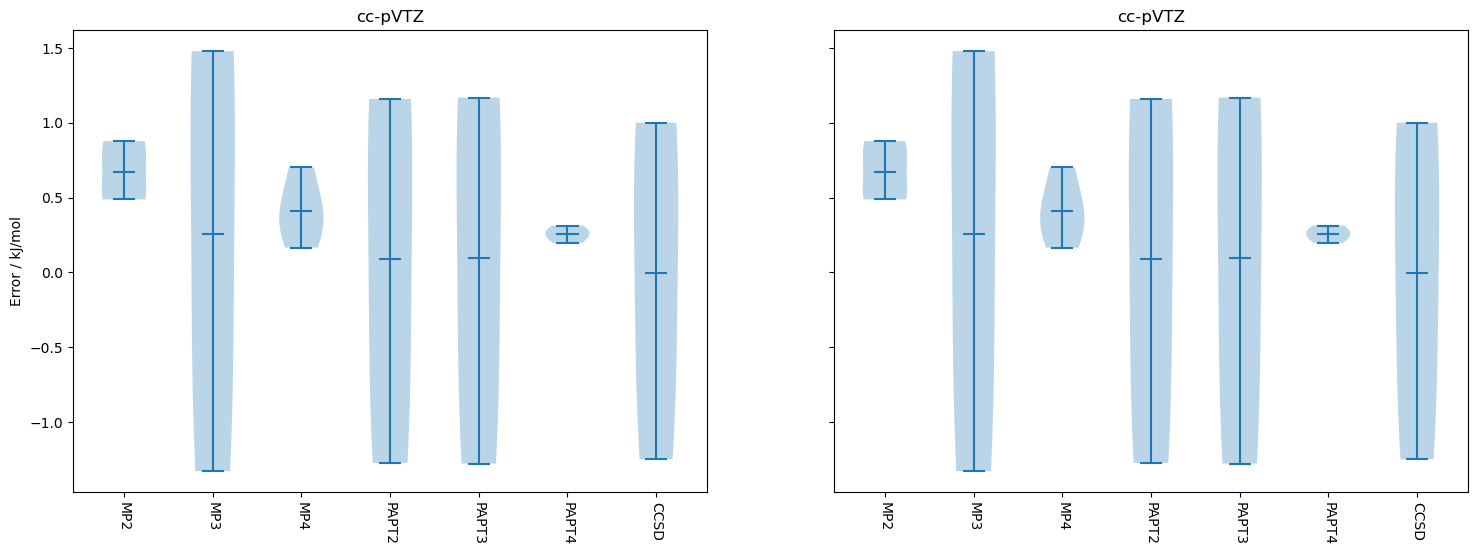

In [21]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if (method != 'HF') and (method != 'CCSD(T)')]
bases_pruned = ['cc-pVTZ', 'cc-pVTZ']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      results['CCSD(T)']['cc-pVTZ'],'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")
df = pd.DataFrame(data)
df.to_excel("PAPT.xlsx")

In [20]:
extrapolate=pymolpro.database.basis_extrapolate(results[method].values(), results["HF"].values())
extrapolate